# **TCN model - feature set 1 dynamic and static data**

We will now adapt our TCN model to work with static data.





We want to apply the same experiment design to our TCN network as was applied to the LSTM network.

Hyperparameters to be tuned:
- Dropout rate
- Activation function
- Learning rate
- L2 regularisation weight decay
- Sampling type
- Weighted Loss

TCN specific:
- Number of layers in temporal block
- Number of channels
- Kernel size

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
import torch.nn.utils.parametrizations as param
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import json

**Handling Data**

In [ ]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, static_features, labels):
        self.sequences = sequences
        self.static_features = static_features
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            'sequence': torch.tensor(self.sequences[idx].transpose(1, 0), dtype=torch.float32),  # Transpose to (num_features, num_timesteps)
            'static': torch.tensor(self.static_features[idx], dtype=torch.float32),
            'label': torch.tensor(self.labels[idx], dtype=torch.float32)
        }

In [ ]:
def create_data_loaders(train_sequences, train_static, train_labels, val_sequences, val_static, val_labels, test_sequences, test_static, test_labels, batch_size):
    train_dataset = TimeSeriesDataset(train_sequences, train_static, train_labels)
    val_dataset = TimeSeriesDataset(val_sequences, val_static, val_labels)
    test_dataset = TimeSeriesDataset(test_sequences, test_static, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

**Undersampling and Oversampling**

In [ ]:
def undersample_data(sequences, static, labels):
    """
    Undersamples the data using RandomUnderSampler.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Undersampled sequences, static features, and labels.
    """
    rus = RandomUnderSampler()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    combined_features = np.hstack((sequences_flat, static))
    combined_resampled, labels_resampled = rus.fit_resample(combined_features, labels)
    sequences_resampled = combined_resampled[:, :sequences_flat.shape[1]].reshape((-1, sequences.shape[1], sequences.shape[2]))
    static_resampled = combined_resampled[:, sequences_flat.shape[1]:]
    return sequences_resampled, static_resampled, labels_resampled

def oversample_data(sequences, static, labels):
    """
    Oversamples the data using SMOTE.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Oversampled sequences, static features, and labels.
    """
    smote = SMOTE()
    sequences_flat = sequences.reshape(sequences.shape[0], -1)
    combined_features = np.hstack((sequences_flat, static))
    combined_resampled, labels_resampled = smote.fit_resample(combined_features, labels)
    sequences_resampled = combined_resampled[:, :sequences_flat.shape[1]].reshape((-1, sequences.shape[1], sequences.shape[2]))
    static_resampled = combined_resampled[:, sequences_flat.shape[1]:]
    return sequences_resampled, static_resampled, labels_resampled

**Early Stopping**

In [ ]:
class EarlyStopping:
    def __init__(self, output_path, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.output_path = output_path

    def __call__(self, val_auc, model):
        if self.best_score is None:
            self.best_score = val_auc
            self.save_checkpoint(model)
        elif val_auc < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_auc
            self.save_checkpoint(model)
            self.counter = 0

    def save_checkpoint(self, model):
        torch.save(model.state_dict(), self.output_path)

### **Define the TCN model**


Model archeicture is adapted from the paper by Bai et al. (https://arxiv.org/pdf/1803.01271), whcih defines a generic TCN architecture.

https://github.com/locuslab/TCN/blob/master/TCN/tcn.py is their github repo for reference.

Elements are also taken from Catling et al. (https://pubmed.ncbi.nlm.nih.gov/31858114/).

**Chomp1d layer**

Removes extra padding introduced by dilations to maintain the correct sequence length

In [ ]:
# Class designed to trim the end of a sequence - ensuring output length matches input length after padding and dilations
class Chomp1d(nn.Module):
  def __init__(self, chomp_size):
    super(Chomp1d, self).__init__()
    self.chomp_size = chomp_size # The number of elements to remove from the end of the sequence

  def forward(self, x):
    return x[:, :, :-self.chomp_size].contiguous() # Returns the trimmed sequence

**TemporalBlock layer**

Defines a single block of TCN.


In [ ]:
class TemporalBlock(nn.Module):
  def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout):
    super(TemporalBlock, self).__init__()

    # First dilated convolutional layer
    self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp1 = Chomp1d(padding) # Trim the output of conv 1 to remove padding added for dilation
    self.relu1 = nn.ReLU()
    self.bn1 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout1 = nn.Dropout(dropout) # Spatial dropout

    # Second dilated convolutional layer
    self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                       stride=stride, padding=padding, dilation=dilation)
    self.chomp2 = Chomp1d(padding) # Trim the output of conv 2 to remove padding added for dilation
    self.relu2 = nn.ReLU()
    self.bn2 = nn.BatchNorm1d(n_outputs) # Batch normlisation to make training more robust
    self.dropout2 = nn.Dropout(dropout) # Spatial dropout

    # Sequential container
    self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.bn1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.bn2, self.dropout2)

    # 1x1 convolutional layer for downsampling if the number of input channels is not equal to the number of output channels
    self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
    self.relu = nn.ReLU()
    self.init_weights()

  # Function to initialize weights of the convolutional layers
  def init_weights(self):
    for layer in self.net:
        if isinstance(layer, nn.Conv1d):
            nn.init.kaiming_normal_(layer.weight)  # Use Kaiming Normal initialization
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)  # Initialize biases to 0
    if self.downsample is not None:
        nn.init.kaiming_normal_(self.downsample.weight)  # Use Kaiming Normal initialization for downsample
        if self.downsample.bias is not None:
            nn.init.constant_(self.downsample.bias, 0)  # Initialize biases to 0

  # Define forward pass funcion
  def forward(self, x):
    out = self.net(x) # Pass input through the sequential container
    res = x if self.downsample is None else self.downsample(x) # If the number of input channels is not equal to the number of output channels, use the 1x1 convolutional layer to downsample the input
    return self.relu(out + res) # Add the residual connection and pass the output through a ReLU activation function

**TemporalConvNet**

Stacks multiple Temporal Blocks to form a TCN network.

To integrate static data, a fully connected layer is added to the previous architecture.

In [ ]:
class TCN(nn.Module):
  def __init__(self, num_inputs, num_channels, kernel_size, dropout, seq_length, static_input_size):
    super(TCN, self).__init__()

    layers = []
    num_levels = len(num_channels) # Number of temporal blocks

    for i in range(num_levels):
      dilation_size = 2 ** i # Dilation factor for each temporal block
      in_channels = num_inputs if i == 0 else num_channels[i-1] # Input channels as either num_inputs or output channels from previous block
      out_channels = num_channels[i] # Output channels for current block

      # Append temporal blocks to create network layers
      layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                               dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]

      # Stride kept at 1 to preserve sequence length of temporal data and maintain casual convolutions

      # Create sequential container
      self.network = nn.Sequential(*layers)

      self.static_linear = nn.Linear(static_input_size, num_channels[-1]) # Fully connected layer for static data
      self.combined_linear = nn.Linear(num_channels[-1] * seq_length + num_channels[-1], 1) # Combined linear layer for output

      self.sigmoid = nn.Sigmoid() # Sigmoid activation function for binary classification
      self.init_weights() # Initialize weights of the network

  # Function to initialize weights of the linear layer
  def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

  # Define forward pass function
  def forward(self, x, static):
    x = self.network(x) # Pass input through the network layers
    x = x.view(x.size(0), -1) # Flatten the output of the network layers

    static_out = self.static_linear(static) # Pass static data through the fully connected layer
    combined = torch.cat((x, static_out), dim=1) # Concatenate the output of the network layers and static data
    x = self.combined_linear(combined) # Pass the concatenated output through the combined linear layer

    x = self.sigmoid(x) # Pass through sigmoid activation function
    return x

**Training model**

In [ ]:
def train_model_with_early_stopping_logging(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, output_path):
    model.to(device)
    best_model_wts = model.state_dict()
    best_auc = 0.0

    # Initialise early stopping
    early_stopping = EarlyStopping(patience=patience, min_delta=0, output_path=output_path)

    train_losses = []
    val_losses = []
    val_aucs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences, static)



            # DEBUG - Debugging prints for outputs and labels
            if torch.isnan(outputs).any():
                print(f"NaN detected in outputs at epoch {epoch}")
                print(f"outputs: {outputs}")
            if torch.isnan(labels).any():
                print(f"NaN detected in labels at epoch {epoch}")
                print(f"labels: {labels}")

            # DEBUG - Check for values out of range [0, 1] in outputs
            if (outputs < 0).any() or (outputs > 1).any():
                print(f"Out of range values detected in outputs at epoch {epoch}")
                print(f"outputs: {outputs}")
                return model, train_losses, val_losses, val_aucs



            loss = criterion(outputs, labels)
            loss.backward()

            # Add gradient clipping with max_norm value set to 1 to help prevent exploding gradient problem
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        val_outputs = []
        val_labels = []
        with torch.no_grad():
            for data in val_loader:
                sequences = data['sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)
                outputs = model(sequences, static)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * sequences.size(0)
                val_outputs.extend(outputs.cpu().numpy().flatten())
                val_labels.extend(labels.cpu().numpy().flatten())

        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        # DEBUG - heck for NaN values in val_outputs and val_labels
        if np.isnan(val_outputs).any() or np.isnan(val_labels).any():
            print(f"NaN detected in validation outputs or labels at epoch {epoch}")
            print(f"val_outputs: {val_outputs}")
            print(f"val_labels: {val_labels}")
            return model, train_losses, val_losses, val_aucs

        val_auc = roc_auc_score(val_labels, val_outputs)
        val_aucs.append(val_auc)

        early_stopping(val_auc, model)

        if val_auc > best_auc:
            best_auc = val_auc
            best_model_wts = model.state_dict()

        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}')

        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, val_aucs

**Cross-validation**

In [ ]:
def shuffle_data(sequences, static, labels):
    """
    Shuffles the sequences, static features, and labels in unison.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.

    Returns:
        tuple: Shuffled sequences, static features, and labels.
    """
    assert len(sequences) == len(static) == len(labels)
    p = np.random.permutation(len(sequences))
    return sequences[p], static[p], labels[p]

In [ ]:
def split_data_into_folds(sequences, static, labels, num_folds):
    """
    Splits the data into the specified number of folds for cross-validation.

    Args:
        sequences (numpy.ndarray): Time series sequences.
        static (numpy.ndarray): Static features.
        labels (numpy.ndarray): Corresponding labels.
        num_folds (int): Number of folds for cross-validation.

    Returns:
        tuple: Lists of sequences, static features, and labels split into folds.
    """
    fold_size = len(sequences) // num_folds
    sequences_folds = []
    static_folds = []
    labels_folds = []

    for i in range(num_folds):
        start = i * fold_size
        end = (i + 1) * fold_size if i != num_folds - 1 else len(sequences)
        sequences_folds.append(sequences[start:end])
        static_folds.append(static[start:end])
        labels_folds.append(labels[start:end])

    return sequences_folds, static_folds, labels_folds

In [ ]:
def reset_model(model):
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [ ]:
def manual_cross_validation(sequences, static, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    sequences, static, labels = shuffle_data(sequences, static, labels)
    sequences_folds, static_folds, labels_folds = split_data_into_folds(sequences, static, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_sequences = sequences_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        input_dim = train_sequences.shape[2]
        seq_length = train_sequences.shape[1]
        static_input_size = train_static.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
            else:
                train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels

            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_static_resampled, train_labels_resampled,
                val_sequences, val_static, val_labels,
                val_sequences, val_static, val_labels,
                batch_size=params['batch_size']
            )

            model = TCN(
                num_inputs=input_dim,
                num_channels=params['num_channels'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout'],
                seq_length=seq_length,
                static_input_size=static_input_size
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            # Add gradient clipping to prevent numerical instability with exploding gradients
            # optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'], clip_grad_norm=1.0)  # Add clip_grad_norm


            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(sequences, static)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc

**Bayesian Optimisation for Hyperparameter Tuning**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


In [ ]:
import optuna

In [ ]:
# Run Bayesian optimization
def objective_wrapper(train_sequences, train_static, train_labels, seq_length, hyperparameter_grid):
    def objective(trial):
        num_channels_str = trial.suggest_categorical('num_channels', hyperparameter_grid['num_channels'])
        num_channels = tuple(map(int, num_channels_str.split(',')))

        kernel_size = trial.suggest_int('kernel_size', min(hyperparameter_grid['kernel_size']), max(hyperparameter_grid['kernel_size']))
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']))
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'seq_length': seq_length
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc = manual_cross_validation(
            train_sequences,
            train_static,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Final model training**

In [ ]:
def train_final_model(model, train_loader, criterion, optimizer, num_epochs, device, grad_clip=1.0):
    """
    Train the model with the given parameters and plot the training loss.

    Parameters:
    model (nn.Module): The neural network model to be trained.
    train_loader (DataLoader): The DataLoader for the training dataset.
    criterion (nn.Module): The loss function.
    optimizer (torch.optim.Optimizer): The optimizer.
    num_epochs (int): The number of epochs to train the model.
    device (torch.device): The device to train the model on.
    grad_clip (float): Gradient clipping threshold.

    Returns:
    nn.Module: The trained model.
    list: The list of training losses over epochs.
    """
    model.to(device)
    model.train()

    train_losses = []

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in train_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)

            optimizer.zero_grad()
            outputs = model(sequences, static)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)  # Gradient clipping
            optimizer.step()
            running_loss += loss.item() * sequences.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}')

    # Plot the training losses at the end of training
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Loss Over Epochs')
    plt.grid(True)
    plt.show()

    return model, train_losses

**Model evaluation**

In [ ]:
def evaluate_model(model, test_loader, device):
    """
    Evaluate the model on the test dataset and calculate various evaluation metrics.

    Parameters:
    model (nn.Module): The trained model to evaluate.
    test_loader (DataLoader): The DataLoader for the test dataset.
    device (torch.device): The device to run the model on.

    Returns:
    tuple: A tuple containing accuracy, precision, recall, F1 score, ROC AUC, and specificity.
    """
    model.eval()
    test_outputs = []
    test_labels = []
    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]
            outputs = model(sequences, static)
            test_outputs.extend(outputs.cpu().numpy().flatten())
            test_labels.extend(labels.cpu().numpy().flatten())

    test_outputs = np.array(test_outputs)
    test_labels = np.array(test_labels)

    # Calculate various metrics
    accuracy = accuracy_score(test_labels, test_outputs.round())
    precision = precision_score(test_labels, test_outputs.round())
    recall = recall_score(test_labels, test_outputs.round())
    f1 = f1_score(test_labels, test_outputs.round())
    roc_auc = roc_auc_score(test_labels, test_outputs)
    tn, fp, fn, tp = confusion_matrix(test_labels, test_outputs.round()).ravel()
    specificity = tn / (tn + fp)
    sensitivity = recall

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall (Sensitivity): {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC: {roc_auc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    return accuracy, precision, recall, f1, roc_auc, specificity

**Feature ablation**

In [ ]:
def evaluate_model_ablation(model, data_loader, criterion, device):
    model.eval()
    all_labels = []
    all_outputs = []
    total_loss = 0.0

    with torch.no_grad():
        for data in data_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences, static)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * sequences.size(0)

            all_outputs.extend(outputs.cpu().numpy().flatten())
            all_labels.extend(labels.cpu().numpy().flatten())

    avg_loss = total_loss / len(data_loader.dataset)
    accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
    roc_auc = roc_auc_score(all_labels, all_outputs)
    specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

    return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from collections import defaultdict

def feature_ablation_with_names(train_sequences, train_static, train_labels, test_sequences, test_static, test_labels, model, best_hyperparams, device, feature_names_dynamic, feature_names_static):
    """
    Perform feature ablation by retraining the model without each feature.

    Parameters:
    train_sequences (np.array): The training sequences.
    train_static (np.array): The training static features.
    train_labels (np.array): The training labels.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The test labels.
    model (nn.Module): The trained TCN model.
    best_hyperparams (dict): The best hyperparameters.
    device (torch.device): The device to run the model on.
    feature_names_dynamic (list): List of dynamic feature names.
    feature_names_static (list): List of static feature names.

    Returns:
    pd.DataFrame: DataFrame containing the feature importances.
    """
    def evaluate_model_ablation(model, data_loader, criterion, device):
        model.eval()
        all_labels = []
        all_outputs = []
        total_loss = 0.0

        with torch.no_grad():
            for data in data_loader:
                sequences = data['sequence'].to(device)
                static = data['static'].to(device)
                labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

                outputs = model(sequences, static)
                loss = criterion(outputs, labels)
                total_loss += loss.item() * sequences.size(0)

                all_outputs.extend(outputs.cpu().numpy().flatten())
                all_labels.extend(labels.cpu().numpy().flatten())

        avg_loss = total_loss / len(data_loader.dataset)
        accuracy = accuracy_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        precision = precision_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        recall = recall_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        f1 = f1_score(all_labels, (np.array(all_outputs) > 0.5).astype(int))
        roc_auc = roc_auc_score(all_labels, all_outputs)
        specificity = recall_score(all_labels, (np.array(all_outputs) <= 0.5).astype(int))

        return avg_loss, accuracy, precision, recall, f1, roc_auc, specificity

    feature_importances = defaultdict(dict)
    input_dim_dynamic = train_sequences.shape[2]
    input_dim_static = train_static.shape[1]

    criterion = nn.BCELoss()
    _, base_accuracy, base_precision, base_recall, base_f1, base_roc_auc, base_specificity = evaluate_model_ablation(
        model,
        DataLoader(TimeSeriesDataset(test_sequences, test_static, test_labels), batch_size=best_hyperparams['batch_size'], shuffle=False),
        criterion,
        device
    )

    # Ablation for dynamic features
    for feature_idx in range(input_dim_dynamic):
        feature_name = feature_names_dynamic[feature_idx]
        print(f"Ablating dynamic feature {feature_name} ({feature_idx + 1}/{input_dim_dynamic})")

        # Remove the feature from the sequences
        train_sequences_ablation = np.delete(train_sequences, feature_idx, axis=2)
        test_sequences_ablation = np.delete(test_sequences, feature_idx, axis=2)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences_ablation, train_static, train_labels,
            train_sequences_ablation, train_static, train_labels,
            test_sequences_ablation, test_static, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = TCN(
            num_inputs=train_sequences_ablation.shape[2],
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_length=train_sequences_ablation.shape[1],
            static_input_size=train_static.shape[1]
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['dynamic'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Ablation for static features
    for feature_idx in range(input_dim_static):
        feature_name = feature_names_static[feature_idx]
        print(f"Ablating static feature {feature_name} ({feature_idx + 1}/{input_dim_static})")

        # Remove the feature from the static data
        train_static_ablation = np.delete(train_static, feature_idx, axis=1)
        test_static_ablation = np.delete(test_static, feature_idx, axis=1)

        # Create data loaders
        train_loader, val_loader, test_loader = create_data_loaders(
            train_sequences, train_static_ablation, train_labels,
            train_sequences, train_static_ablation, train_labels,
            test_sequences, test_static_ablation, test_labels,
            batch_size=best_hyperparams['batch_size']
        )

        # Initialize a new model for this ablation
        ablation_model = TCN(
            num_inputs=input_dim_dynamic,
            num_channels=[int(x) for x in best_hyperparams['num_channels'].split(',')],
            kernel_size=best_hyperparams['kernel_size'],
            dropout=best_hyperparams['dropout_prob'],
            seq_length=train_sequences.shape[1],
            static_input_size=train_static_ablation.shape[1]
        ).to(device)

        optimizer = torch.optim.Adam(ablation_model.parameters(), lr=best_hyperparams['learning_rate'])

        # Train the model
        ablation_model, _, _, _ = train_model_with_early_stopping_logging(
            ablation_model, train_loader, val_loader, criterion, optimizer,
            best_hyperparams['num_epochs'], device, patience=5, output_path='checkpoint.pth'
        )

        # Evaluate the model
        _, accuracy, precision, recall, f1, roc_auc, specificity = evaluate_model_ablation(ablation_model, test_loader, criterion, device)

        feature_importances['static'][feature_name] = {
            'accuracy': base_accuracy - accuracy,
            'precision': base_precision - precision,
            'recall': base_recall - recall,
            'f1': base_f1 - f1,
            'roc_auc': base_roc_auc - roc_auc,
            'specificity': base_specificity - specificity
        }

    # Combine feature importances for plotting
    combined_feature_importances = {**feature_importances['dynamic'], **feature_importances['static']}

    # Convert feature importances to DataFrames for better readability
    dynamic_importances_df = pd.DataFrame.from_dict(feature_importances['dynamic'], orient='index').sort_values(by='roc_auc', ascending=False)
    static_importances_df = pd.DataFrame.from_dict(feature_importances['static'], orient='index').sort_values(by='roc_auc', ascending=False)
    combined_importances_df = pd.DataFrame.from_dict(combined_feature_importances, orient='index').sort_values(by='roc_auc', ascending=False)

    # Plot dynamic feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(dynamic_importances_df.index, dynamic_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Dynamic Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot static feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(static_importances_df.index, static_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Static Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    # Plot combined feature importance
    plt.figure(figsize=(12, 8))
    plt.barh(combined_importances_df.index, combined_importances_df['roc_auc'], align='center', alpha=0.7)
    plt.xlabel('Change in ROC_AUC')
    plt.title('Combined Feature Importance based on change in ROC_AUC')
    plt.gca().invert_yaxis()
    plt.show()

    return combined_importances_df

**Confusion matrix**

In [ ]:
def get_model_predictions(model, test_loader, device):
    """
    Get model predictions and true labels from the test data.

    Parameters:
    model (nn.Module): Trained model.
    test_loader (DataLoader): DataLoader for the test data.
    device (torch.device): Device to run the model on (CPU or GPU).

    Returns:
    tuple: A tuple containing true labels, predicted labels, and output scores.
    """
    model.to(device)
    model.eval()

    y_true = []
    y_pred = []
    y_scores = []

    with torch.no_grad():
        for data in test_loader:
            sequences = data['sequence'].to(device)
            static = data['static'].to(device)
            labels = data['label'].to(device).view(-1, 1)  # Ensure labels have shape [batch_size, 1]

            outputs = model(sequences, static)

            preds = (outputs >= 0.5).float()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())

    return np.array(y_true), np.array(y_pred), np.array(y_scores)

In [ ]:
def plot_confusion_matrix(cm, class_names):
    """
    Plot the confusion matrix using seaborn heatmap.

    Parameters:
    cm (array-like): Confusion matrix.
    class_names (list): List of class names.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names
class_names = ['Success', 'Failure']  # Replace with your actual class names if different

**Plot ROC curve**

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import torch

def plot_roc_curve(model, test_sequences, test_static, test_labels, device):
    """
    Generates and plots the ROC curve for the given model and test data.

    Parameters:
    model (torch.nn.Module): The trained model.
    test_sequences (numpy.array): The test sequences data.
    test_static (numpy.array): The test static data.
    test_labels (numpy.array): The true labels for the test data.
    device (torch.device): The device to run the model on (CPU or GPU).

    Returns:
    None
    """

    # Ensure test_sequences and test_static are numpy arrays and then convert them to PyTorch tensors
    test_sequences_tensor = torch.tensor(test_sequences, dtype=torch.float32).to(device)
    test_static_tensor = torch.tensor(test_static, dtype=torch.float32).to(device)

    # Ensure the sequence data is in the shape [batch_size, num_features, num_time_steps]
    if test_sequences_tensor.dim() == 3 and test_sequences_tensor.size(1) > test_sequences_tensor.size(2):
        test_sequences_tensor = test_sequences_tensor.transpose(1, 2)

    # Ensure the model is in evaluation mode
    model.eval()

    # Make predictions
    with torch.no_grad():
        predictions = model(test_sequences_tensor, test_static_tensor)

    # Extract predictions as a numpy array
    predictions_np = predictions.cpu().numpy().flatten()

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions_np)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f'AUC: {roc_auc_score(test_labels, predictions_np):.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

**Best threshold**

In [ ]:
import numpy as np
import torch
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

def find_best_threshold_roc_auc(model, test_sequences, test_static, test_labels, device):
    """
    Find the best classification threshold based on the ROC AUC score and calculate evaluation metrics.

    Parameters:
    model (nn.Module): The trained model.
    test_sequences (np.array): The test sequences.
    test_static (np.array): The test static features.
    test_labels (np.array): The true labels for the test data.
    device (torch.device): The device to run the model on.

    Returns:
    float: The best classification threshold.
    """
    model.eval()  # Set the model to evaluation mode

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for i in range(len(test_sequences)):
            sequence = test_sequences[i]
            static = test_static[i]
            label = test_labels[i]

            # Convert sequence and static features to torch tensors
            sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0).to(device)
            static_tensor = torch.tensor(static, dtype=torch.float32).unsqueeze(0).to(device)

            # Ensure the sequence data is in the shape [batch_size, num_features, num_time_steps]
            if sequence_tensor.dim() == 3 and sequence_tensor.size(1) > sequence_tensor.size(2):
                sequence_tensor = sequence_tensor.transpose(1, 2)

            # Get model output (predicted probabilities)
            output = model(sequence_tensor, static_tensor)

            # Append predicted probabilities and true labels
            all_probs.extend(output.cpu().numpy().flatten())
            all_labels.extend([label])

    # Convert lists to numpy arrays
    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

    # Find the best threshold based on the ROC AUC score
    best_roc_auc = 0
    best_threshold = 0
    for threshold in thresholds:
        predictions = (all_probs >= threshold).astype(int)
        roc_auc = roc_auc_score(all_labels, predictions)
        if roc_auc > best_roc_auc:
            best_roc_auc = roc_auc
            best_threshold = threshold

    # Final predictions using the best threshold
    final_preds = (all_probs >= best_threshold).astype(int)

    # Calculate the final evaluation metrics
    accuracy = accuracy_score(all_labels, final_preds)
    precision = precision_score(all_labels, final_preds)
    recall = recall_score(all_labels, final_preds)
    f1 = f1_score(all_labels, final_preds)
    roc_auc = roc_auc_score(all_labels, all_probs)  # Use probabilities for ROC AUC
    specificity = recall_score(all_labels, final_preds, pos_label=0)

    print(f"Best threshold: {best_threshold:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Specificity: {specificity:.4f}")

    return best_threshold

**Load the data**

In [ ]:
# Load the train and test sequences
train_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_sequences_v3.npy'
train_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_labels_v3.npy'
test_sequences_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_sequences_v3.npy'
test_labels_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_labels_v3.npy'

train_sequences = np.load(train_sequences_path, allow_pickle=True).astype(np.float32)
train_labels = np.load(train_labels_path, allow_pickle=True).astype(np.float32)
test_sequences = np.load(test_sequences_path, allow_pickle=True).astype(np.float32)
test_labels = np.load(test_labels_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train sequences shape: {train_sequences.shape}")
print(f"Train labels shape: {train_labels.shape}")
print(f"Test sequences shape: {test_sequences.shape}")
print(f"Test labels shape: {test_labels.shape}")

Train sequences shape: (3760, 13, 12)
Train labels shape: (3760,)
Test sequences shape: (941, 13, 12)
Test labels shape: (941,)


In [ ]:
seq_length = train_sequences.shape[1]
seq_length

13

In [ ]:
# Load the feature names path
feature_names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/feature_names_v3.npy'
feature_names = np.load(feature_names_path, allow_pickle=True)

# Print the shape of the loaded feature names
print(f"Feature names shape: {feature_names.shape}")

Feature names shape: (12,)


In [ ]:
# Load the static data
train_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_combined_v2.npy'
test_static_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/test_combined_v2.npy'

train_static = np.load(train_static_path, allow_pickle=True).astype(np.float32)
test_static = np.load(test_static_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train static shape: {train_static.shape}")
print(f"Test static shape: {test_static.shape}")

Train static shape: (3760, 37)
Test static shape: (941, 37)


In [ ]:
# Load the train and test subject id order from the dynamic data
train_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/train_subject_ids_v3.npy'
test_subject_id_order_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/test_subject_ids_v3.npy'

train_subject_id_order = np.load(train_subject_id_order_path, allow_pickle=True).astype(np.float32)
test_subject_id_order = np.load(test_subject_id_order_path, allow_pickle=True).astype(np.float32)

# Print the shapes of the loaded data
print(f"Train subject id order shape: {train_subject_id_order.shape}")
print(f"Test subject id order shape: {test_subject_id_order.shape}")

Train subject id order shape: (3760,)
Test subject id order shape: (941,)


In [ ]:
train_static_copy = train_static.copy()
test_static_copy = test_static.copy()

In [ ]:
# Order the rows in the static data to match the dynamic subject id order

# Create a dictionary mapping from subject_id to static features
static_data_dict = {row[0]: row[1:] for row in train_static}

# Reorder static data to match the order of train_subject_id_order
train_static = np.array([static_data_dict[subject_id] for subject_id in train_subject_id_order])

print(f"Train static shape: {train_static.shape}")

Train static shape: (3760, 36)


In [ ]:
# Look at the columns in the static data
train_static_df = pd.DataFrame(train_static)
train_static_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,0.307331,0.250000,0.337538,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.100564,0.104167,0.175384,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.890038,0.791667,0.595601,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.824248,0.520833,0.676008,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.131579,0.250000,0.168071,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:
test_static_data_dict = {row[0]: row[1:] for row in test_static}

# Reorder static data to match the order of test_subject_id_order
test_static = np.array([test_static_data_dict[subject_id] for subject_id in test_subject_id_order])

print(f"Test static shape: {test_static.shape}")

Test static shape: (941, 36)


# **Run the model on dummy data**

We will run the model on dummy data first before the MIMIC data to ensure the model is running smoothly.



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
import torch

# Set the environment variable for CUDA assertions
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Check CUDA availability
print("CUDA available:", torch.cuda.is_available())

# Set manual seed
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Create a simple tensor and move to GPU (if available)
tensor = torch.tensor([1.0, 2.0, 3.0])
if torch.cuda.is_available():
    tensor = tensor.to('cuda')

print("Tensor:", tensor)


CUDA available: False
Tensor: tensor([1., 2., 3.])


In [ ]:
# Generate dummy data
np.random.seed(42)
torch.manual_seed(42)

num_samples = 100
num_time_steps = 13
num_features = 10

X_dummy = np.random.rand(num_samples, num_time_steps, num_features).astype(np.float32)
y_dummy = np.random.randint(0, 2, size=num_samples).astype(np.float32)

In [ ]:
X_dummy.shape, y_dummy.shape

((100, 13, 10), (100,))

In [ ]:
# Define two hyperparameter combinations
hyperparameters = [
    {
        'num_channels': [16, 32],
        'kernel_size': 2,
        'dropout': 0.3,
        'learning_rate': 0.001,
        'weight_decay': 0.01,
        'batch_size': 16,
        'num_epochs': 5,
        'sampling_method': 'normal',
        'loss': 'standard'
    },
    {
        'num_channels': [32, 64],
        'kernel_size': 3,
        'dropout': 0.4,
        'learning_rate': 0.01,
        'weight_decay': 0.1,
        'batch_size': 32,
        'num_epochs': 5,
        'sampling_method': 'normal',
        'loss': 'standard'
    }
]

In [ ]:
# Run the grid search cross validation
dummy_best_model, dummy_best_hyperparams, dummy_best_auc = manual_cross_validation(
    X_dummy,
    y_dummy,
    hyperparameters,
    num_folds=5,
    patience=5,
    output_path="None"
)

Epoch 0/4, Loss: 0.6989, Val Loss: 0.6968, Val AUC: 0.3838
Epoch 1/4, Loss: 0.6918, Val Loss: 0.7084, Val AUC: 0.4242
Epoch 2/4, Loss: 0.6844, Val Loss: 0.7155, Val AUC: 0.4141
Epoch 3/4, Loss: 0.6844, Val Loss: 0.7143, Val AUC: 0.4141
Epoch 4/4, Loss: 0.6859, Val Loss: 0.7163, Val AUC: 0.4040
Params: {'num_channels': [16, 32], 'kernel_size': 2, 'dropout': 0.3, 'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 16, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard'}, Val AUC: 0.4040
Epoch 0/4, Loss: 0.6910, Val Loss: 0.7477, Val AUC: 0.5354
Epoch 1/4, Loss: 0.6938, Val Loss: 0.7143, Val AUC: 0.6364
Epoch 2/4, Loss: 0.6890, Val Loss: 0.7068, Val AUC: 0.3939
Epoch 3/4, Loss: 0.6870, Val Loss: 0.7003, Val AUC: 0.4040
Epoch 4/4, Loss: 0.6892, Val Loss: 0.7002, Val AUC: 0.6061
Params: {'num_channels': [32, 64], 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.01, 'weight_decay': 0.1, 'batch_size': 32, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard

KeyboardInterrupt: 

In [ ]:
print(f"Best hyperparameters: {dummy_best_hyperparams}")
print(f"Best AUC: {dummy_best_auc}")

Best hyperparameters: {'num_channels': [32, 64], 'kernel_size': 3, 'dropout': 0.4, 'learning_rate': 0.01, 'weight_decay': 0.1, 'batch_size': 32, 'num_epochs': 5, 'sampling_method': 'normal', 'loss': 'standard'}
Best AUC: 0.6900000000000001


The model seems to run with no dimensional issues so we can now run our data.

# **Experiment 1**

We will load the time series data and run Bayesian optimisation for hyperparameter tuning.

In [ ]:
import itertools

In [ ]:
# Hyperparameter grid
param_grid_exp_1 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.2, 0.4, 0.6, 0.8],
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2]
}

param_combinations = list(itertools.product(*param_grid_exp_1.values()))

param_combinations = [dict(zip(param_grid_exp_1.keys(), combination))
  for combination in param_combinations]


print(f"Number of hyperparameter combinations: {len(param_combinations)}")

Number of hyperparameter combinations: 1512000


**TCN specific hyperparameters**

num_channels: Starting with smaller values (like [16, 32]) ensures the model starts with fewer parameters and computational cost. Increasing to larger values (like [64, 128, 256]) allows the model to capture more complex patterns in the data. Including configurations with three layers provides an opportunity to explore deeper network architectures, which can be beneficial for capturing hierarchical features in time series data.

kernel_size: Kernel sizes from 2 to 10 provide a broad range of temporal receptive fields. Smaller kernels (like 2) focus on very local patterns, whereas larger kernels (up to 10) can capture more extended temporal dependencies. This range allows the model to adapt to the temporal structure of the data, whether short-term or long-term dependencies are more important.


**Run the Bayesian Optimisation**

As with LSTM we will run Bayesian Optimisation with 100 trials.



In [ ]:
study_exp_1 = optuna.create_study(direction='maximize')
study_exp_1.optimize(objective_wrapper(train_sequences, train_static, train_labels, seq_legth, param_grid_exp_1), n_trials=100)

best_params = study_exp_1.best_params
best_score = study_exp_1.best_value

# Save best hyperparams
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params, f)

print(f"Best hyperparameters: {best_params}")
print(f"Best AUC: {best_score}")

Output hidden; open in https://colab.research.google.com to view.

Best hyperparameters: {'num_channels': '32,64', 'kernel_size': 6, 'dropout_prob': 0.8, 'learning_rate': 1e-05, 'batch_size': 128, 'num_epochs': 69, 'sampling_method': 'undersample', 'loss': 'normal', 'weight_decay': 0.01}

Best AUC: -0.5023688883114633

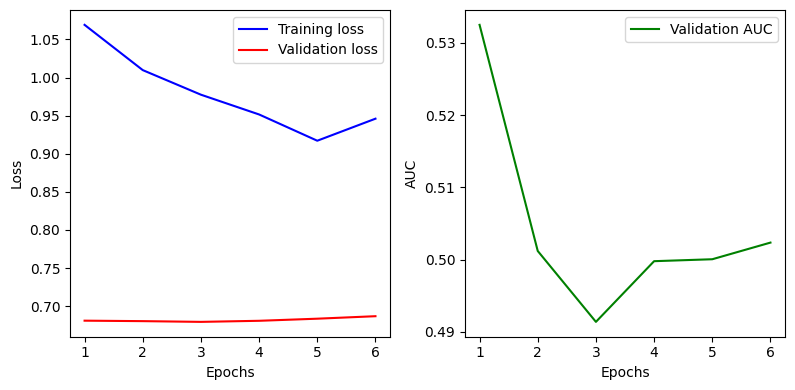

The validation AUC for the combination of best hyperparameters is worse than the performance of the model with just dynamic data.

This may indicate that the static data is not informative and/or that the static data is not being integrated in an optimal way.

**Model training and evaluation**

In [ ]:
# Load the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_1/best_params.json'
with open(params_path, 'r') as f:
    best_params = json.load(f)

best_params

{'num_channels': '32,64',
 'kernel_size': 6,
 'dropout_prob': 0.8,
 'learning_rate': 1e-05,
 'batch_size': 128,
 'num_epochs': 69,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.01}

We will change the num_epochs to 70 to reflect a round number as common practice.

In [ ]:
# Round the num_epochs to the nearest 10
best_params['num_epochs'] = round(best_params['num_epochs'], -1)
best_params

{'num_channels': '32,64',
 'kernel_size': 6,
 'dropout_prob': 0.8,
 'learning_rate': 1e-05,
 'batch_size': 128,
 'num_epochs': 70,
 'sampling_method': 'undersample',
 'loss': 'normal',
 'weight_decay': 0.01}

In [ ]:
# Define the final model
final_model_exp_1 = TCN(
    num_inputs=train_sequences.shape[2],
    num_channels=[int(x) for x in best_params['num_channels'].split(',')],
    kernel_size=best_params['kernel_size'],
    dropout=best_params['dropout_prob'],
    seq_length=train_sequences.shape[1],
    static_input_size=train_static.shape[1]
).to(device)

final_model_exp_1

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.8, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.8, inplace=False)
      (net): Sequential(
        (0): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (1): Chomp1d()
        (2): ReLU()
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.8, inplace=False)
        (5): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (6): Chomp1d()
        (7): ReLU()
        (8): BatchNorm1d(

In [ ]:
# Handle sampling methods
if best_params['sampling_method'] == 'undersample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
elif best_params['sampling_method'] == 'oversample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
else:
  train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels

# Define the loss function
if best_params['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model_exp_1.parameters(),
    lr=best_params['learning_rate'],
    weight_decay=best_params['weight_decay']
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
train_loader, _, test_loader = create_data_loaders(
    train_sequences_resampled, train_static_resampled, train_labels_resampled,
    _, _, _,
    test_sequences, test_static, test_labels,
    batch_size=best_params['batch_size']
)

In [ ]:
reset_model(final_model_exp_1)

Epoch 1/70, Loss: 0.9214
Epoch 2/70, Loss: 0.8815
Epoch 3/70, Loss: 0.9095
Epoch 4/70, Loss: 0.9009
Epoch 5/70, Loss: 0.8665
Epoch 6/70, Loss: 0.8992
Epoch 7/70, Loss: 0.8836
Epoch 8/70, Loss: 0.9208
Epoch 9/70, Loss: 0.8894
Epoch 10/70, Loss: 0.8595
Epoch 11/70, Loss: 0.8754
Epoch 12/70, Loss: 0.8746
Epoch 13/70, Loss: 0.8662
Epoch 14/70, Loss: 0.8599
Epoch 15/70, Loss: 0.8583
Epoch 16/70, Loss: 0.8667
Epoch 17/70, Loss: 0.8576
Epoch 18/70, Loss: 0.8383
Epoch 19/70, Loss: 0.8669
Epoch 20/70, Loss: 0.8603
Epoch 21/70, Loss: 0.8919
Epoch 22/70, Loss: 0.8554
Epoch 23/70, Loss: 0.8562
Epoch 24/70, Loss: 0.8626
Epoch 25/70, Loss: 0.8852
Epoch 26/70, Loss: 0.8755
Epoch 27/70, Loss: 0.8592
Epoch 28/70, Loss: 0.8585
Epoch 29/70, Loss: 0.8537
Epoch 30/70, Loss: 0.8606
Epoch 31/70, Loss: 0.8492
Epoch 32/70, Loss: 0.8474
Epoch 33/70, Loss: 0.8325
Epoch 34/70, Loss: 0.8813
Epoch 35/70, Loss: 0.8453
Epoch 36/70, Loss: 0.8557
Epoch 37/70, Loss: 0.8552
Epoch 38/70, Loss: 0.8368
Epoch 39/70, Loss: 0.

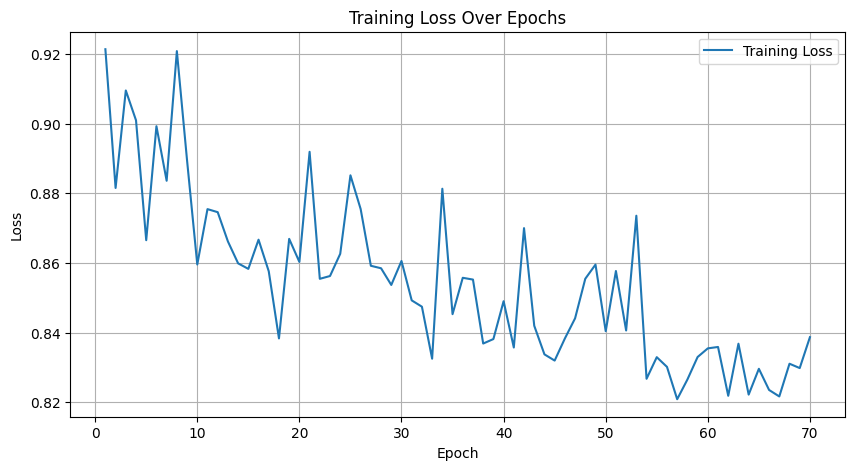

In [ ]:
# Train the model on the full training data
final_model_exp_1, train_losses = train_final_model(
    final_model_exp_1,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params['num_epochs'],
    device=device,
)

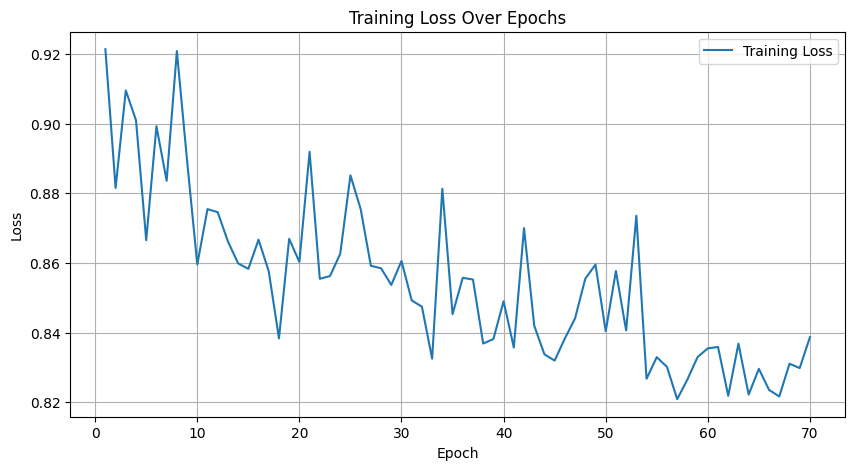

The loss starts a lot higher than all other models.

In [ ]:
# Save the model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_1/final_model.pkl'
with open(model_path, 'wb') as file:
    pickle.dump(final_model_exp_1, file)

**Evaluate the final model**

In [ ]:
# Evaluate the model
evaluate_model(final_model_exp_1, test_loader, device)

Accuracy: 0.5016
Precision: 0.3283
Recall (Sensitivity): 0.4951
F1 Score: 0.3948
ROC AUC: 0.5103
Specificity: 0.5047


(0.5015940488841658,
 0.3283261802575107,
 0.49514563106796117,
 0.39483870967741935,
 0.5103129736594157,
 0.504746835443038)

Accuracy: 0.5016
Precision: 0.3283
Recall (Sensitivity): 0.4951
F1 Score: 0.3948
ROC AUC: 0.5103
Specificity: 0.5047

Interestingly it is not just predicting one class over another as per previous attempts.

**Analyse Confusion Matrix**

In [ ]:
# Load the model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_1/final_model.pkl'
with open(model_path, 'rb') as file:
    final_model_exp_1 = pickle.load(file)

final_model_exp_1

TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.8, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.8, inplace=False)
      (net): Sequential(
        (0): Conv1d(12, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (1): Chomp1d()
        (2): ReLU()
        (3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.8, inplace=False)
        (5): Conv1d(32, 32, kernel_size=(6,), stride=(1,), padding=(5,))
        (6): Chomp1d()
        (7): ReLU()
        (8): BatchNorm1d(

In [ ]:
# Get the model preductions
y_true, y_pred, y_scores = get_model_predictions(final_model_exp_1, test_loader, device)

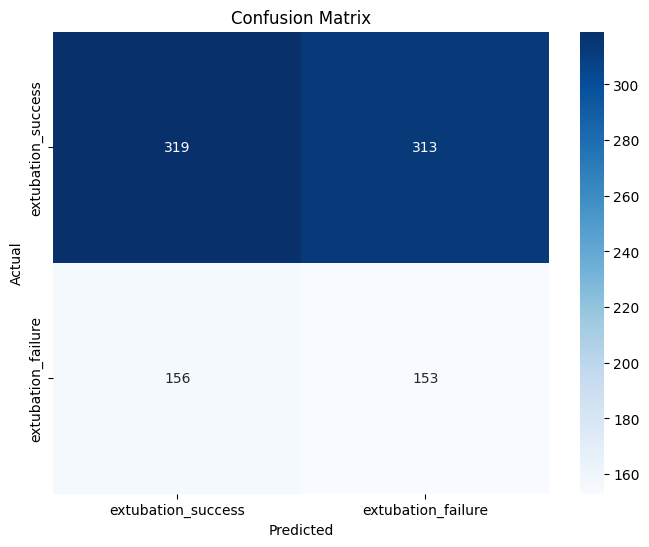

In [ ]:
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
class_names = ['extubation_success', 'extubation_failure']
plot_confusion_matrix(cm, class_names)

Interestingly, this model is essentially predicting 50% success and 50% failure despite the data sampling being set to normal i.e. failure is a minority class.

The accuracy is 50% however.

**Plot ROC Curve**

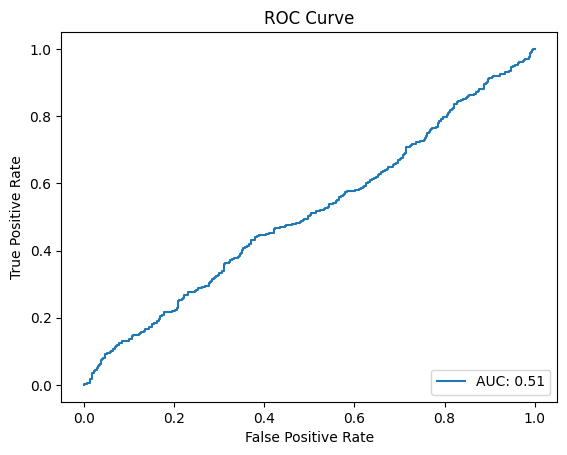

In [ ]:
plot_roc_curve(final_model_exp_1, test_sequences, test_static, test_labels, device)

The ROC curve is still not ideal.

**Best threshold**

It might be the case that the best threshold is a different value to 0.5 so we can investigate.

In [ ]:
best_threshold = find_best_threshold_roc_auc(final_model_exp_1, test_sequences, test_static, test_labels, device)

Best threshold: 0.5045
Accuracy: 0.5611
Precision: 0.3617
Recall: 0.4401
F1 Score: 0.3971
ROC AUC: 0.5103
Specificity: 0.6203


The final threshold is still around 0.5 but the improvement in performance is minimal (EXPLAIN WHY).

### **Model Interpretability**

**Feture ablation**

In [ ]:
# Load static feature names
train_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/static_data/train_static_final_v2.parquet'
train_df = pd.read_parquet(train_path)
static_feature_names = train_df.columns.tolist()

# Remove subject_id from the feature list
static_feature_names.remove('subject_id')

# Print the shape of the loaded feature names
print(f"Feature names shape: {len(static_feature_names)}")

Feature names shape: 36


In [ ]:
# Get the feature names
dynamic_feature_names_path = '/content/drive/MyDrive/MSc_Final_Project/02_data_analysis/mimic/data_analysis/datasets/08_model_input_data/01_feature_set_1/01_lstm_data/dynamic_data/preprocessing_run_2/final_sequences/feature_names_v3.npy'
dynamic_feature_names = np.load(dynamic_feature_names_path, allow_pickle=True)

# Print the shape of the loaded feature names
print(f"Feature names shape: {dynamic_feature_names.shape}")

dynamic_feature_names = dynamic_feature_names.tolist()
dynamic_feature_names

Feature names shape: (12,)


['Inspired O2 Fraction',
 'Tidal Volume (observed)',
 'Tidal Volume (spontaneous)',
 'Minute Volume',
 'Peak Insp. Pressure',
 'Respiratory Rate',
 'O2 saturation pulseoxymetry',
 'Arterial O2 pressure',
 'Arterial CO2 Pressure',
 'PH (Arterial)',
 'SpO2:FiO2',
 'P:F ratio']

Ablating dynamic feature Inspired O2 Fraction (1/12)
Epoch 0/69, Loss: 1.3333, Val Loss: 0.6549, Val AUC: 0.5264
Epoch 1/69, Loss: 1.3547, Val Loss: 0.6516, Val AUC: 0.5321
Epoch 2/69, Loss: 1.3892, Val Loss: 0.6528, Val AUC: 0.5291
Epoch 3/69, Loss: 1.3043, Val Loss: 0.6565, Val AUC: 0.5252
Epoch 4/69, Loss: 1.3070, Val Loss: 0.6580, Val AUC: 0.5259
Epoch 5/69, Loss: 1.3189, Val Loss: 0.6596, Val AUC: 0.5258
Epoch 6/69, Loss: 1.3103, Val Loss: 0.6612, Val AUC: 0.5249
Early stopping
Ablating dynamic feature Tidal Volume (observed) (2/12)
Epoch 0/69, Loss: 1.6238, Val Loss: 0.7101, Val AUC: 0.4649
Epoch 1/69, Loss: 1.5438, Val Loss: 0.7207, Val AUC: 0.4448
Epoch 2/69, Loss: 1.5888, Val Loss: 0.7236, Val AUC: 0.4443
Epoch 3/69, Loss: 1.4100, Val Loss: 0.7189, Val AUC: 0.4430
Epoch 4/69, Loss: 1.3971, Val Loss: 0.7135, Val AUC: 0.4451
Epoch 5/69, Loss: 1.4516, Val Loss: 0.7095, Val AUC: 0.4438
Early stopping
Ablating dynamic feature Tidal Volume (spontaneous) (3/12)
Epoch 0/69, Loss: 1.87

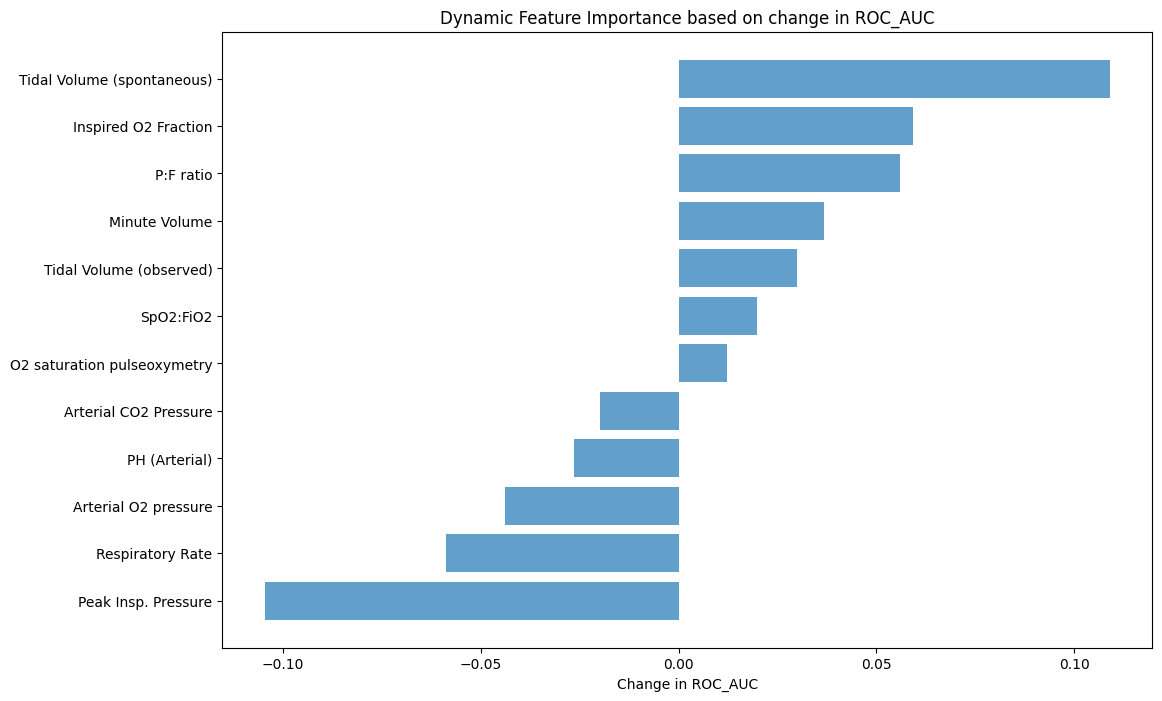

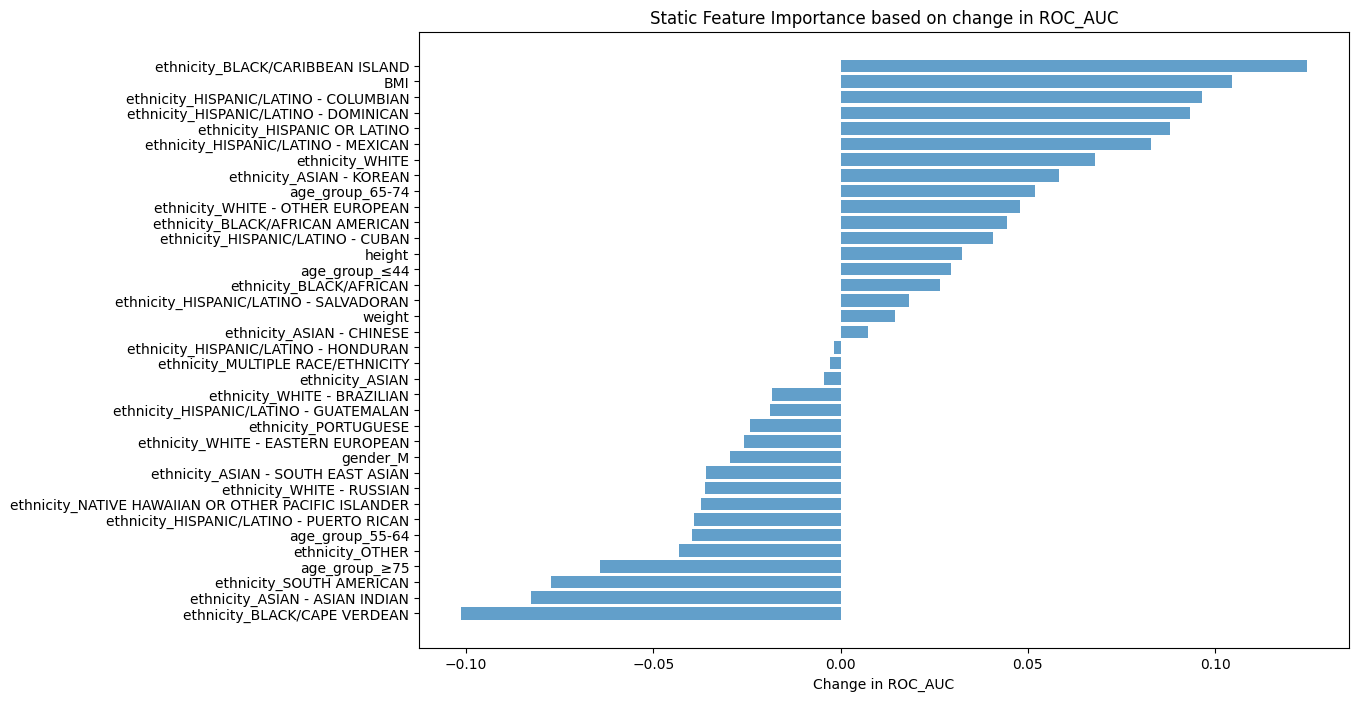

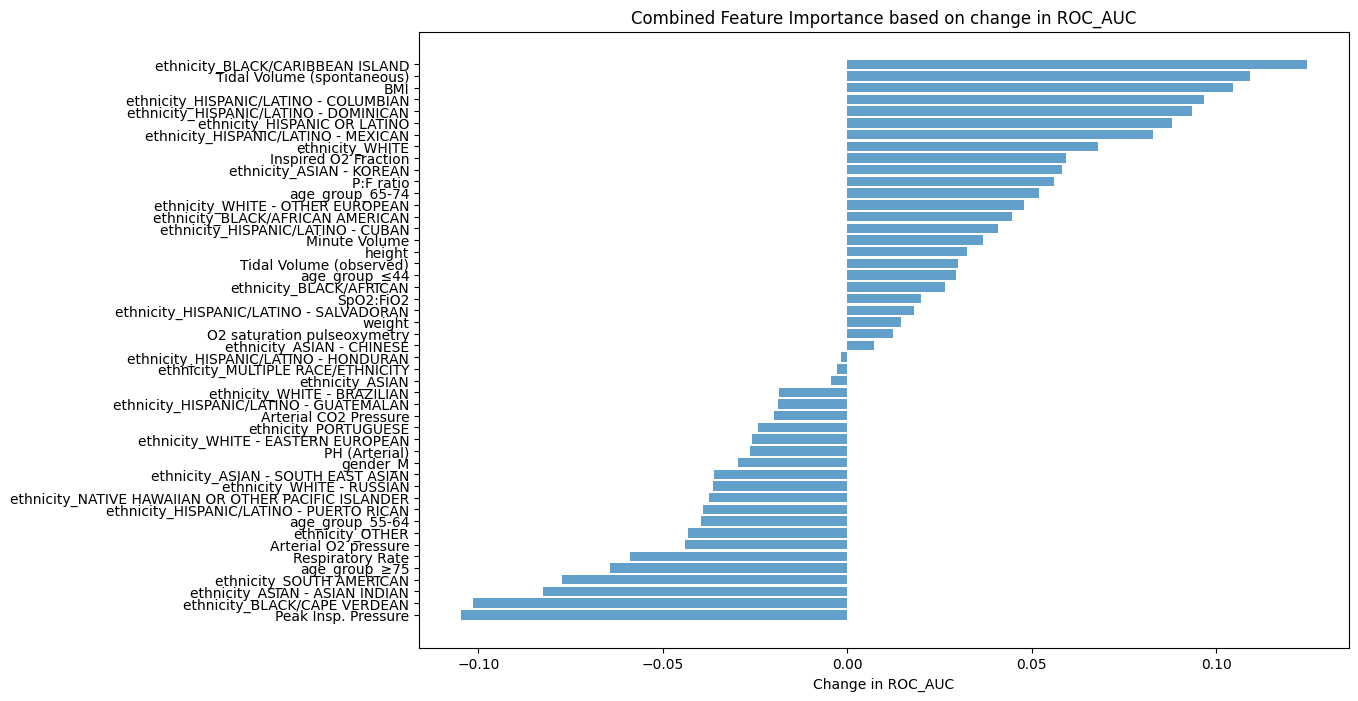

In [ ]:
# Run feature ablation
feature_importances_exp_1 = feature_ablation_with_names(train_sequences, train_static, train_labels, test_sequences, test_static, test_labels, final_model_exp_1, best_params, device, dynamic_feature_names, static_feature_names)

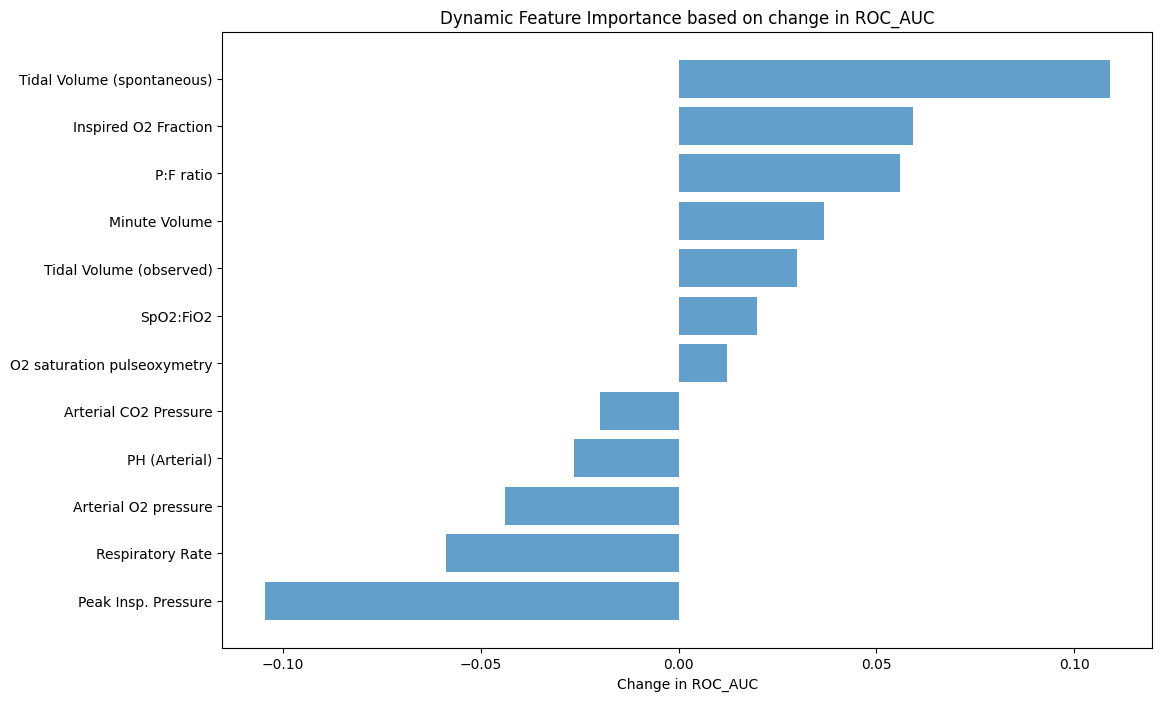

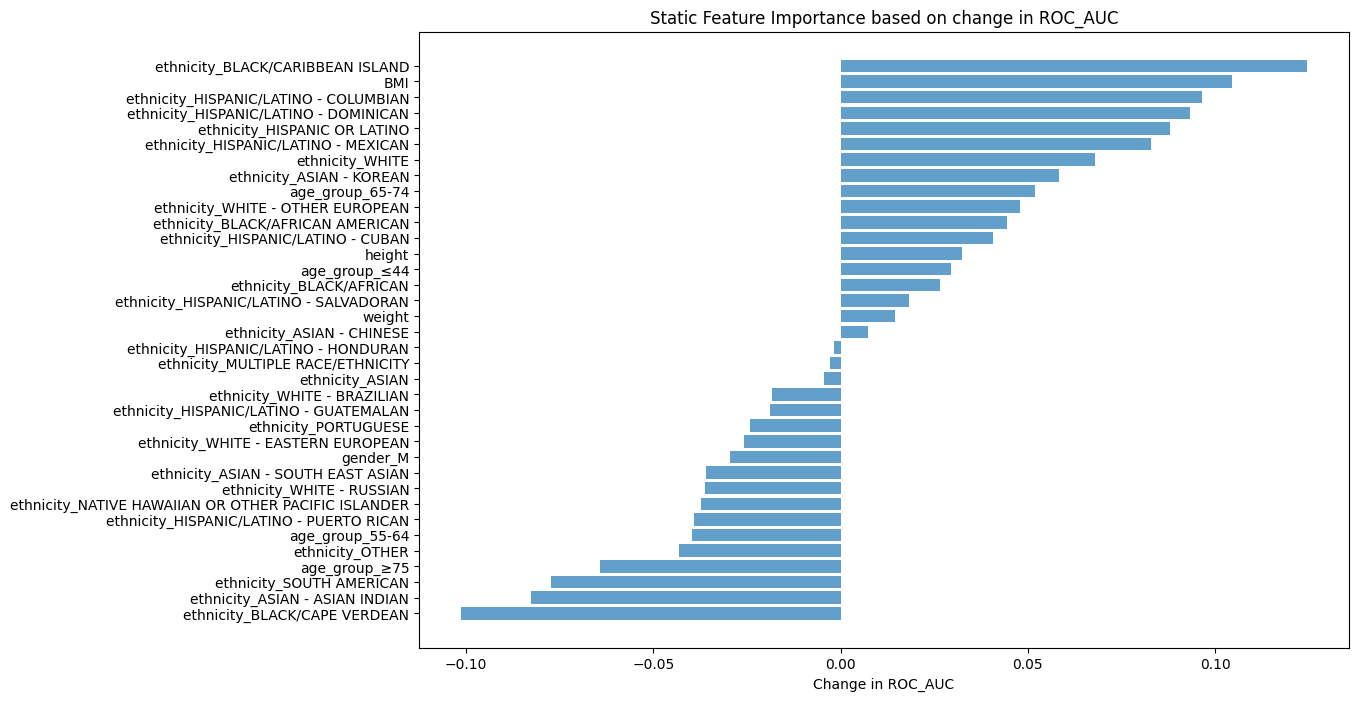

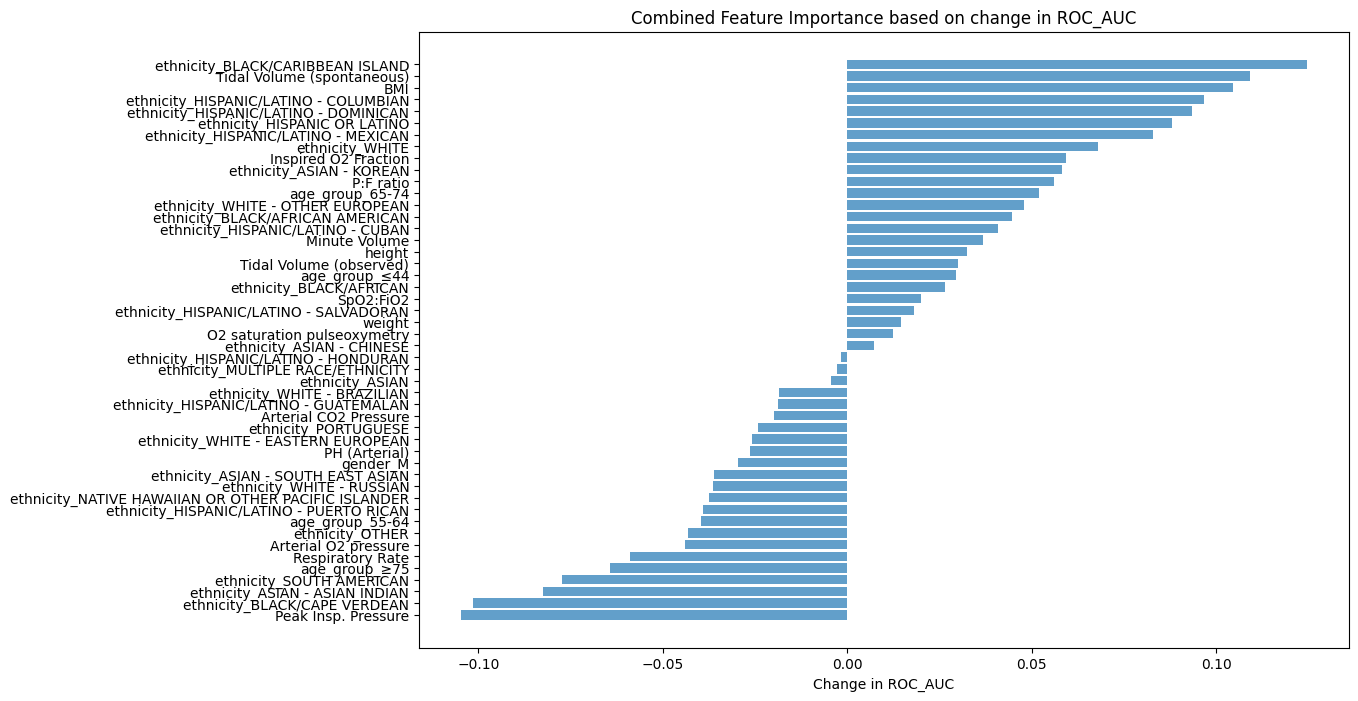

# **Experiment 2**

**Discussion - Feature integration**

We are currently implementing LATE INTEGRATION where a separate neural network is applied to the static data and the output is combined with the dynamic data at the final layer of the TCN prior to sigmoid function.

Alternatives would be EARLY and INTERMEDIATE integration.

### **Discussion - Static data handling**

Currently static data is just being passed into a Linear layer but Catling et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7647248/) instead passes it through a Feed-Forward Neural Network and then concatenate the output of both to then form a prediction. This allows more sophistaicated processing of the static data which may imporve performance.

In experiment 2 we will apply this design of a TCN-FFNN and compare performance.

**Hyperparameters for the FFNN will be included alongside those for the TCN previously.**

### **Experiment 2 - Define TCN-FFNN**

The Chomp1d and TemporalBlock classes will remain the same as the dynamic data will be handled purely by the TCN.

The TCN class will need to be amended to incorporate a FFNN with hyperparameters that can be tuned for both the TCN and the FFNN.

The design for the FFNN layer comes from (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7647248/)

In [ ]:
class TCN_FFNN(nn.Module):
  def __init__(self, num_inputs, num_channels, kernel_size, dropout, seq_length, static_input_size, ffnn_layers, ffnn_units, ffnn_activation, ffnn_dropout):
    super(TCN_FFNN, self).__init__()

    # TCN
    tcn_layers = []
    num_levels = len(num_channels) # Number of temporal blocks

    for i in range(num_levels):
      dilation_size = 2 ** i # Dilation factor for each temporal block
      in_channels = num_inputs if i == 0 else num_channels[i-1] # Input channels as either num_inputs or output channels from previous block
      out_channels = num_channels[i] # Output channels for current block

      # Append temporal blocks to create network layers
      tcn_layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1,
                               dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]

    self.tcn_network = nn.Sequential(*tcn_layers)
    self.tcn_linear = nn.Linear(num_channels[-1] * seq_length, num_channels[-1])

    # FFNN
    ffnn_layers_list = []
    input_dim = static_input_size
    for _ in range(ffnn_layers):
      ffnn_layers_list.append(nn.Linear(input_dim, ffnn_units)) # Add linear layer
      if ffnn_activation == 'relu':
        ffnn_layers_list.append(nn.ReLU()) # Add ReLU activation function
      elif ffnn_activation == 'tanh':
        ffnn_layers_list.append(nn.Tanh()) # Add Tanh activation function
      elif ffnn_activation == 'sigmoid':
        ffnn_layers_list.append(nn.Sigmoid()) # Add Sigmoid activation function
      elif ffnn_activation == 'leaky_relu':
        ffnn_layers_list.append(nn.LeakyReLU()) # Add LeakyReLU activation function
      ffnn_layers_list.append(nn.Dropout(ffnn_dropout)) # Add dropout layer
      input_dim = ffnn_units # Update input dimension for next layer

    self.ffnn_network = nn.Sequential(*ffnn_layers_list)
    self.ffnn_output = nn.Linear(ffnn_units, num_channels[-1])

    # Combined output
    self.combined_linear = nn.Linear(num_channels[-1] + num_channels[-1], 1) # Combined linear layer for output
    self.sigmoid = nn.Sigmoid()
    self.init_weights()

  # Function to initialize weights of the linear layer
  def init_weights(self):
    for m in self.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

  # Define forward pass function
  def forward(self, x, static):

    # TCN forward pass
    x = self.tcn_network(x) # Pass input through the network layers
    x = x.view(x.size(0), -1) # Flatten the output of the network layers
    x = self.tcn_linear(x) # Pass the flattened output through the fully connected layer

    # FFNN forward pass
    static_out = self.ffnn_network(static) # Pass static data through the fully connected layer
    static_out = self.ffnn_output(static_out) # Pass the output through the fully connected layer

    # Concatenate the output of the network layers and static data
    combined = torch.cat((x, static_out), dim=1) # Concatenate the output of the network layers and static data
    output = self.combined_linear(combined) # Pass the concatenated output through the combined linear layer

    output = self.sigmoid(output) # Pass through sigmoid activation function
    return output

**Cross validation function**

In [ ]:
def tcn_ffnn_manual_cross_validation(sequences, static_data, labels, hyperparameters, num_folds=5, patience=5, output_path=None):
    sequences, static_data, labels = shuffle_data(sequences, static_data, labels)
    sequences_folds, static_folds, labels_folds = split_data_into_folds(sequences, static_data, labels, num_folds)

    best_auc = 0.0
    best_model = None
    best_hyperparams = None

    best_train_losses = None
    best_val_losses = None
    best_val_aucs = None

    for i in range(num_folds):
        val_sequences = sequences_folds[i]
        val_static = static_folds[i]
        val_labels = labels_folds[i]
        train_sequences = np.concatenate([sequences_folds[j] for j in range(num_folds) if j != i])
        train_static = np.concatenate([static_folds[j] for j in range(num_folds) if j != i])
        train_labels = np.concatenate([labels_folds[j] for j in range(num_folds) if j != i])

        input_dim = train_sequences.shape[2]
        seq_length = train_sequences.shape[1]
        static_input_size = train_static.shape[1]

        for params in hyperparameters:
            if params['sampling_method'] == 'undersample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
            elif params['sampling_method'] == 'oversample':
                train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
            else:
                train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels

            train_loader, val_loader, _ = create_data_loaders(
                train_sequences_resampled, train_static_resampled, train_labels_resampled,
                val_sequences, val_static, val_labels,
                val_sequences, val_static, val_labels,
                batch_size=params['batch_size']
            )

            # Model with new hyperparameters
            model = TCN_FFNN(
                num_inputs=input_dim,
                num_channels=params['num_channels'],
                kernel_size=params['kernel_size'],
                dropout=params['dropout_prob'],
                seq_length=seq_length,
                static_input_size=static_input_size,
                ffnn_layers=params['ffnn_layers'],
                ffnn_units=params['ffnn_units'],
                ffnn_activation=params['ffnn_activation'],
                ffnn_dropout=params['ffnn_dropout']
            ).to(device)

            reset_model(model)

            criterion = nn.BCELoss()

            if params['loss'] == 'weighted' and params['sampling_method'] == 'normal':
                pos_weight = torch.tensor([len(train_labels_resampled) / (2.0 * sum(train_labels_resampled))]).to(device)
                criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

            optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])

            model, train_losses, val_losses, val_aucs = train_model_with_early_stopping_logging(
                model, train_loader, val_loader, criterion, optimizer,
                params['num_epochs'], device, patience, output_path
            )

            val_outputs = []
            val_labels = []
            model.eval()
            with torch.no_grad():
                for data in val_loader:
                    sequences = data['sequence'].to(device)
                    static = data['static'].to(device)
                    labels = data['label'].to(device).view(-1, 1)
                    outputs = model(sequences, static)
                    val_outputs.extend(outputs.cpu().numpy().flatten())
                    val_labels.extend(labels.cpu().numpy().flatten())

            val_auc = roc_auc_score(val_labels, val_outputs)
            if val_auc > best_auc:
                best_auc = val_auc
                best_model = model
                best_hyperparams = params
                best_train_losses = train_losses
                best_val_losses = val_losses
                best_val_aucs = val_aucs

            print(f"Params: {params}, Val AUC: {val_auc:.4f}")

    if best_train_losses and best_val_losses and best_val_aucs:
        epochs = range(1, len(best_train_losses) + 1)
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.plot(epochs, best_train_losses, 'b-', label='Training loss')
        plt.plot(epochs, best_val_losses, 'r-', label='Validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 3, 2)
        plt.plot(epochs, best_val_aucs, 'g-', label='Validation AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_val_aucs

**Bayesian Optimisation objective function**

In [ ]:
def tcn_ffnn_objective_wrapper(train_sequences, train_static, train_labels, seq_length, hyperparameter_grid):
    def objective(trial):
        num_channels_str = trial.suggest_categorical('num_channels', hyperparameter_grid['num_channels'])
        num_channels = tuple(map(int, num_channels_str.split(',')))

        kernel_size = trial.suggest_int('kernel_size', min(hyperparameter_grid['kernel_size']), max(hyperparameter_grid['kernel_size']))
        dropout_prob = trial.suggest_categorical('dropout_prob', hyperparameter_grid['dropout_prob'])
        learning_rate = trial.suggest_categorical('learning_rate', hyperparameter_grid['learning_rate'])
        batch_size = trial.suggest_categorical('batch_size', hyperparameter_grid['batch_size'])
        num_epochs = trial.suggest_int('num_epochs', min(hyperparameter_grid['num_epochs']), max(hyperparameter_grid['num_epochs']), step=10)
        sampling_method = trial.suggest_categorical('sampling_method', hyperparameter_grid['sampling_method'])
        loss = trial.suggest_categorical('loss', hyperparameter_grid['loss'])
        weight_decay = trial.suggest_categorical('weight_decay', hyperparameter_grid['weight_decay'])

        ffnn_layers = trial.suggest_int('ffnn_layers', min(hyperparameter_grid['ffnn_layers']), max(hyperparameter_grid['ffnn_layers']))
        ffnn_units = trial.suggest_int('ffnn_units', min(hyperparameter_grid['ffnn_units']), max(hyperparameter_grid['ffnn_units']))
        ffnn_activation = trial.suggest_categorical('ffnn_activation', hyperparameter_grid['ffnn_activation'])
        ffnn_dropout = trial.suggest_categorical('ffnn_dropout', hyperparameter_grid['ffnn_dropout'])

        # Check if weighted loss is used with undersampling or oversampling and skip if so
        if loss == 'weighted' and sampling_method != 'normal':
            raise optuna.TrialPruned()

        hyperparameters = {
            'num_channels': num_channels,
            'kernel_size': kernel_size,
            'dropout_prob': dropout_prob,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'num_epochs': num_epochs,
            'sampling_method': sampling_method,
            'loss': loss,
            'weight_decay': weight_decay,
            'seq_length': seq_length,
            'ffnn_layers': ffnn_layers,
            'ffnn_units': ffnn_units,
            'ffnn_activation': ffnn_activation,
            'ffnn_dropout': ffnn_dropout
        }

        # Run cross-validation
        best_model, best_hyperparams, best_auc, best_train_losses, best_val_losses, best_scores = tcn_ffnn_manual_cross_validation(
            train_sequences,
            train_static,
            train_labels,
            [hyperparameters],
            num_folds=5,
            patience=5,
            output_path="None"
        )

        # Log training and validation losses to Optuna
        for epoch, (train_losse, val_loss) in enumerate(zip(best_train_losses, best_val_losses)):
            trial.report(val_loss, epoch)
            if trial.should_prune():
                raise optuna.TrialPruned()

        # Optuna minimizes the objective, so return the negative AUC
        return -best_auc

    return objective

**Experiment 2 - Hyperparameter tuning**

We will now attempt hyperparameter tuning on our TCN-FFNN model using Bayesian Optimisation.

In [ ]:
import itertools

In [ ]:
# Define new hyperparameter grid
param_grid_exp_2 = {
    'num_channels': [
        '16,32', '32,64', '64,128', '128,256',
        '16,32,64', '32,64,128', '64,128,256'
    ],
    'kernel_size': list(range(2, 11)),  # Kernel sizes from 2 to 10
    'dropout_prob': [0.0, 0.25, 0.5, 0.75], # To mimic LSTM
    'learning_rate': [1e-5, 1e-4, 1e-3, 1e-2],  # Learning rates to explore
    'batch_size': [16, 32, 64, 128, 256],
    'num_epochs': list(range(10, 101, 10)),  # Epochs from 10 to 100
    'sampling_method': ['normal', 'undersample', 'oversample'],
    'loss': ['normal', 'weighted'],
    'weight_decay': [1e-5, 1e-4, 1e-3, 1e-2],
    'ffnn_layers': [1, 2, 3],
    'ffnn_units': [32, 64, 128, 256],
    'ffnn_activation': ['relu', 'tanh', 'sigmoid', 'leaky_relu'],
    'ffnn_dropout': [0.0, 0.25, 0.5, 0.75] # To mimic LSTM range
}

With over 29 million combinations, Bayesian Optimisation is the only logical and efficient way to explore the hyperparameter space.

In [ ]:
# Run Bayesian Optimisation with 100 trials
study_exp_2 = optuna.create_study(direction='minimize')
study_exp_2.optimize(tcn_ffnn_objective_wrapper(train_sequences, train_static, train_labels, seq_length, param_grid_exp_2), n_trials=100)

best_params_exp_2 = study_exp_2.best_params
best_score_exp_2 = study_exp_2.best_value

# Save the best parameters
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_2/best_params.json'
with open(params_path, 'w') as f:
    json.dump(best_params_exp_2, f)

print(f"Best parameters: {best_params_exp_2}")
print(f"Best score: {best_score_exp_2}")

Output hidden; open in https://colab.research.google.com to view.

Best parameters: {'num_channels': '64,128', 'kernel_size': 5, 'dropout_prob': 0.25, 'learning_rate': 0.0001, 'batch_size': 32, 'num_epochs': 50, 'sampling_method': 'normal', 'loss': 'normal', 'weight_decay': 0.0001, 'ffnn_layers': 3, 'ffnn_units': 56, 'ffnn_activation': 'tanh', 'ffnn_dropout': 0.5}

Best score: -0.682960187205515

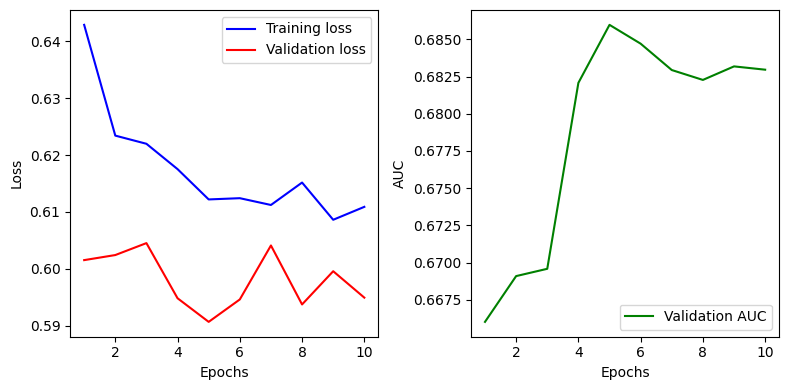

The validation performance is already better than that of the previous architecture.

**Train and evaluate final model**

In [ ]:
# Load the best params
params_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_2/best_params.json'
with open(params_path) as f:
    best_params_exp_2 = json.load(f)

best_params_exp_2

{'num_channels': '64,128',
 'kernel_size': 5,
 'dropout_prob': 0.25,
 'learning_rate': 0.0001,
 'batch_size': 32,
 'num_epochs': 50,
 'sampling_method': 'normal',
 'loss': 'normal',
 'weight_decay': 0.0001,
 'ffnn_layers': 3,
 'ffnn_units': 56,
 'ffnn_activation': 'tanh',
 'ffnn_dropout': 0.5}

In [ ]:
# Define the final model
final_model_exp_2 = TCN_FFNN(
    num_inputs=train_sequences.shape[2],
    num_channels=[int(x) for x in best_params_exp_2['num_channels'].split(',')],
    kernel_size=best_params_exp_2['kernel_size'],
    dropout=best_params_exp_2['dropout_prob'],
    seq_length=train_sequences.shape[1],
    static_input_size=train_static.shape[1],
    ffnn_layers=best_params_exp_2['ffnn_layers'],
    ffnn_units=best_params_exp_2['ffnn_units'],
    ffnn_activation=best_params_exp_2['ffnn_activation'],
    ffnn_dropout=best_params_exp_2['ffnn_dropout']

).to(device)

final_model_exp_2

TCN_FFNN(
  (tcn_network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(12, 64, kernel_size=(5,), stride=(1,), padding=(4,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout1): Dropout(p=0.25, inplace=False)
      (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout2): Dropout(p=0.25, inplace=False)
      (net): Sequential(
        (0): Conv1d(12, 64, kernel_size=(5,), stride=(1,), padding=(4,))
        (1): Chomp1d()
        (2): ReLU()
        (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): Dropout(p=0.25, inplace=False)
        (5): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(4,))
        (6): Chomp1d()
        (7): ReLU()
        (8): 

In [ ]:
# Handle sampling methods
if best_params_exp_2['sampling_method'] == 'undersample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = undersample_data(train_sequences, train_static, train_labels)
elif best_params_exp_2['sampling_method'] == 'oversample':
  train_sequences_resampled, train_static_resampled, train_labels_resampled = oversample_data(train_sequences, train_static, train_labels)
else:
  train_sequences_resampled, train_static_resampled, train_labels_resampled = train_sequences, train_static, train_labels

# Define the loss function
if best_params_exp_2['loss'] == 'weighted':
  pos_weight = torch.tensor([best_params_exp_2['pos_weight']]).to(device)
  criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
else:
  criterion = nn.BCELoss()

# Define the optimiser
optimizer = optim.Adam(
    final_model_exp_2.parameters(),
    lr=best_params_exp_2['learning_rate'],
    weight_decay=best_params_exp_2['weight_decay']
)

# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
train_loader, _, test_loader = create_data_loaders(
    train_sequences_resampled, train_static_resampled, train_labels_resampled,
    _, _, _,
    test_sequences, test_static, test_labels,
    batch_size=best_params_exp_2['batch_size']
)

Epoch 1/50, Loss: 0.8649
Epoch 2/50, Loss: 0.7796
Epoch 3/50, Loss: 0.7507
Epoch 4/50, Loss: 0.7168
Epoch 5/50, Loss: 0.6836
Epoch 6/50, Loss: 0.6925
Epoch 7/50, Loss: 0.6773
Epoch 8/50, Loss: 0.6523
Epoch 9/50, Loss: 0.6479
Epoch 10/50, Loss: 0.6618
Epoch 11/50, Loss: 0.6543
Epoch 12/50, Loss: 0.6397
Epoch 13/50, Loss: 0.6473
Epoch 14/50, Loss: 0.6270
Epoch 15/50, Loss: 0.6347
Epoch 16/50, Loss: 0.6309
Epoch 17/50, Loss: 0.6317
Epoch 18/50, Loss: 0.6281
Epoch 19/50, Loss: 0.6313
Epoch 20/50, Loss: 0.6274
Epoch 21/50, Loss: 0.6292
Epoch 22/50, Loss: 0.6154
Epoch 23/50, Loss: 0.6383
Epoch 24/50, Loss: 0.6253
Epoch 25/50, Loss: 0.6191
Epoch 26/50, Loss: 0.6197
Epoch 27/50, Loss: 0.6233
Epoch 28/50, Loss: 0.6073
Epoch 29/50, Loss: 0.6142
Epoch 30/50, Loss: 0.6240
Epoch 31/50, Loss: 0.6141
Epoch 32/50, Loss: 0.6075
Epoch 33/50, Loss: 0.6256
Epoch 34/50, Loss: 0.6140
Epoch 35/50, Loss: 0.6155
Epoch 36/50, Loss: 0.6169
Epoch 37/50, Loss: 0.6066
Epoch 38/50, Loss: 0.6128
Epoch 39/50, Loss: 0.

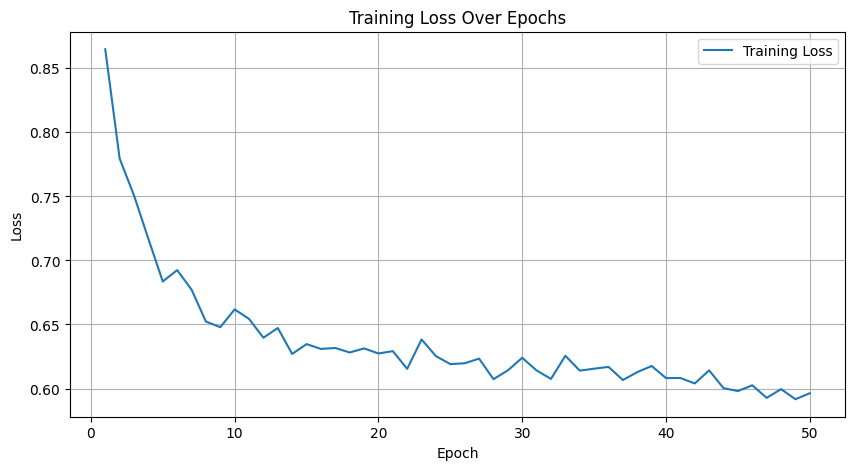

In [ ]:
# Train the final model
final_model_exp_2, train_losses = train_final_model(
    final_model_exp_2,
    train_loader,
    criterion,
    optimizer,
    num_epochs=best_params_exp_2['num_epochs'],
    device=device
)

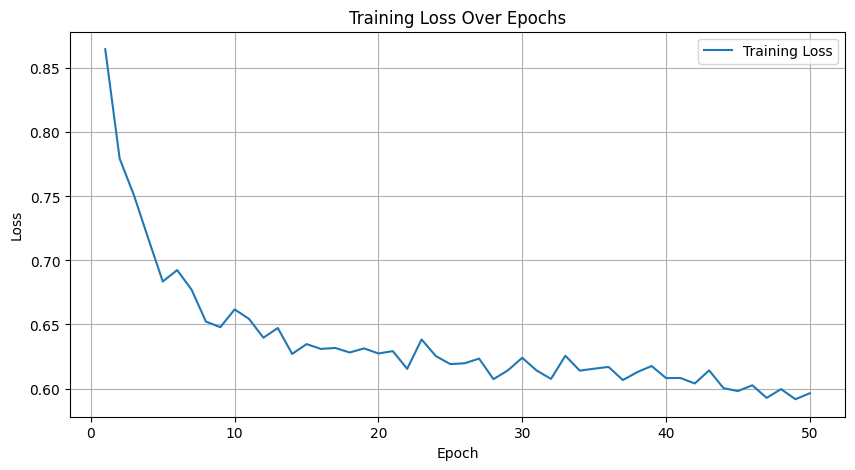

In [ ]:
# Save the trained model
model_path = '/content/drive/MyDrive/MSc_Final_Project/03_model_development/01_feature_set_1/02_tcn_model/02_static_and_dynamic_data/best_models/experiment_2/final_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(final_model_exp_2, f)

**Evaluate final model**

In [ ]:
evaluate_model(final_model_exp_2, test_loader, device)

Accuracy: 0.5940
Precision: 0.4027
Recall (Sensitivity): 0.4887
F1 Score: 0.4415
ROC AUC: 0.5752
Specificity: 0.6456


(0.594048884165781,
 0.4026666666666667,
 0.4886731391585761,
 0.4415204678362573,
 0.5751863913809347,
 0.6455696202531646)

This model performs better on all metrics compared to the previous design.

**Confusion matrix**

In [ ]:
y_true, y_pred, y_scores = get_model_predictions(final_model_exp_2, test_loader, device)

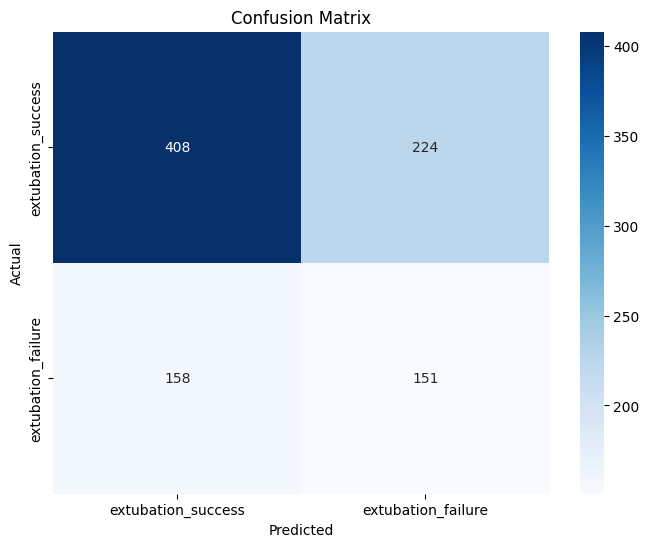

In [ ]:
cm = confusion_matrix(y_true, y_pred)

classes = ['extubation_success', 'extubation_failure']
plot_confusion_matrix(cm, classes)

### **Model Interpretability**

**Feature ablation**

Ablating dynamic feature Inspired O2 Fraction (1/12)
Epoch 0/49, Loss: 0.8185, Val Loss: 0.6307, Val AUC: 0.6067
Epoch 1/49, Loss: 0.7454, Val Loss: 0.6199, Val AUC: 0.6277
Epoch 2/49, Loss: 0.7272, Val Loss: 0.6362, Val AUC: 0.6398
Epoch 3/49, Loss: 0.7025, Val Loss: 0.6055, Val AUC: 0.6478
Epoch 4/49, Loss: 0.6882, Val Loss: 0.6082, Val AUC: 0.6504
Epoch 5/49, Loss: 0.6971, Val Loss: 0.5976, Val AUC: 0.6606
Epoch 6/49, Loss: 0.6812, Val Loss: 0.6107, Val AUC: 0.6620
Epoch 7/49, Loss: 0.6797, Val Loss: 0.5967, Val AUC: 0.6684
Epoch 8/49, Loss: 0.6645, Val Loss: 0.5955, Val AUC: 0.6685
Epoch 9/49, Loss: 0.6603, Val Loss: 0.5988, Val AUC: 0.6752
Epoch 10/49, Loss: 0.6640, Val Loss: 0.5880, Val AUC: 0.6774
Epoch 11/49, Loss: 0.6573, Val Loss: 0.5944, Val AUC: 0.6758
Epoch 12/49, Loss: 0.6523, Val Loss: 0.6033, Val AUC: 0.6777
Epoch 13/49, Loss: 0.6480, Val Loss: 0.5969, Val AUC: 0.6814
Epoch 14/49, Loss: 0.6448, Val Loss: 0.5910, Val AUC: 0.6830
Epoch 15/49, Loss: 0.6341, Val Loss: 0.588

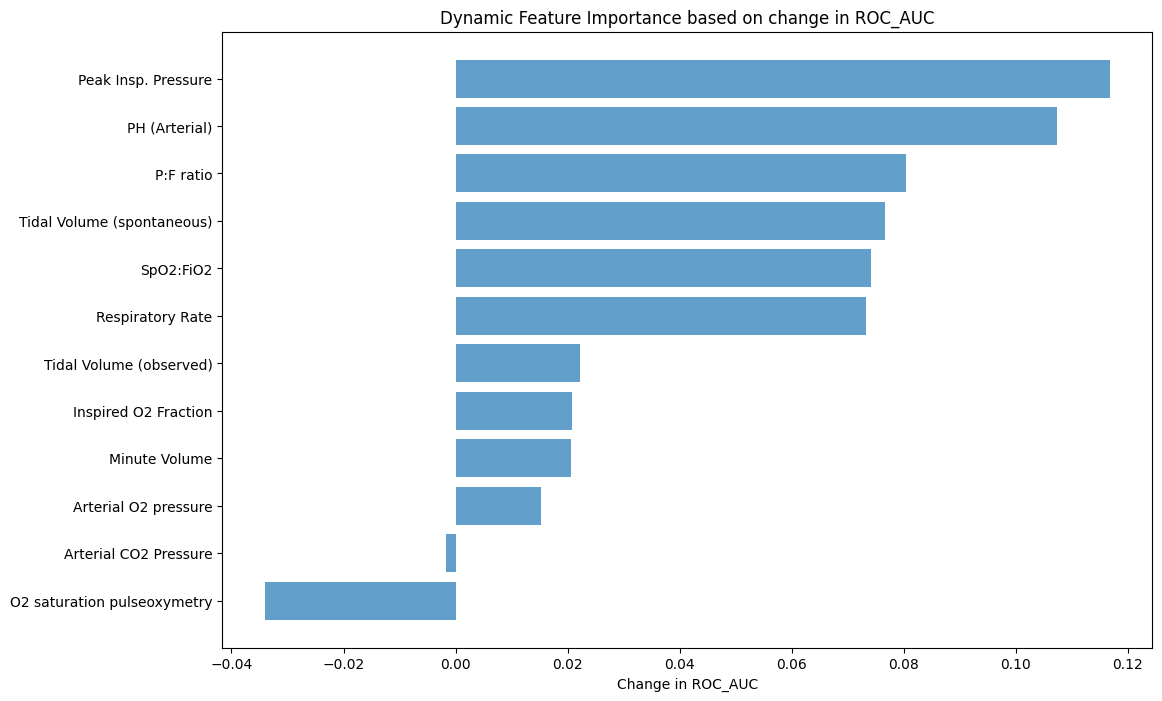

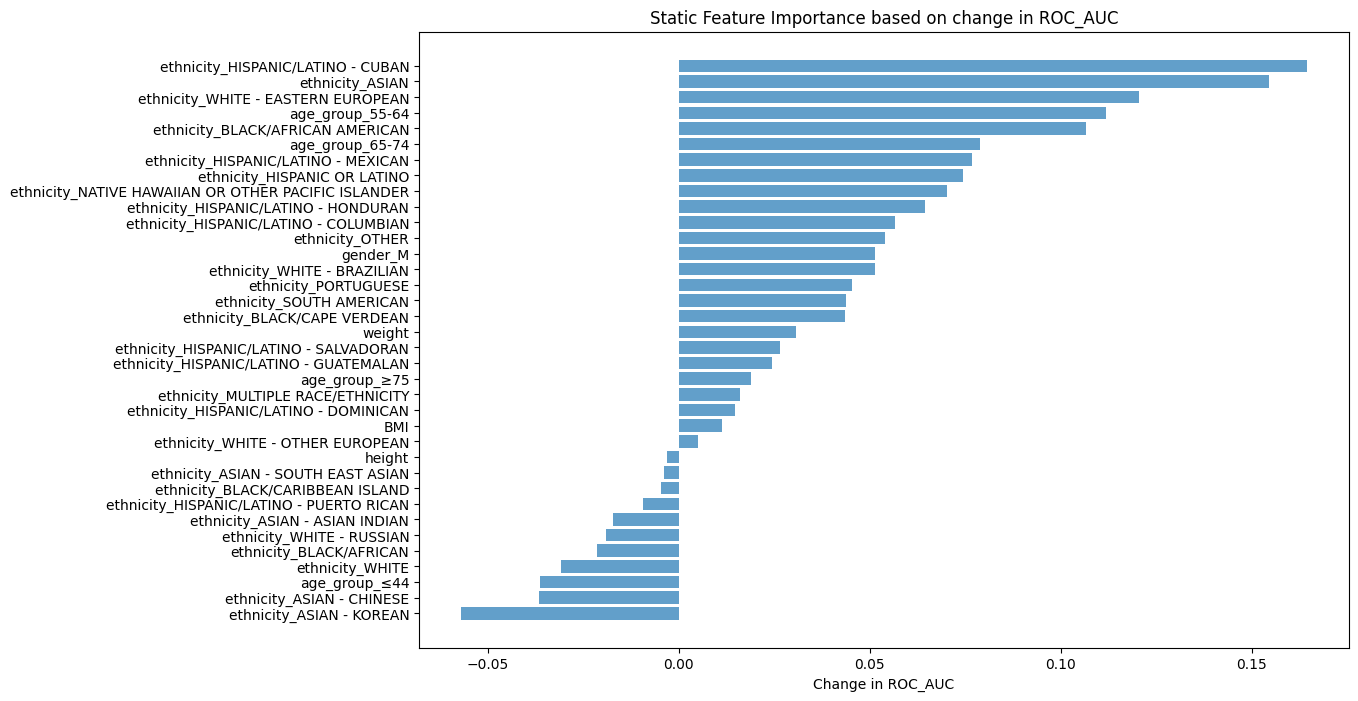

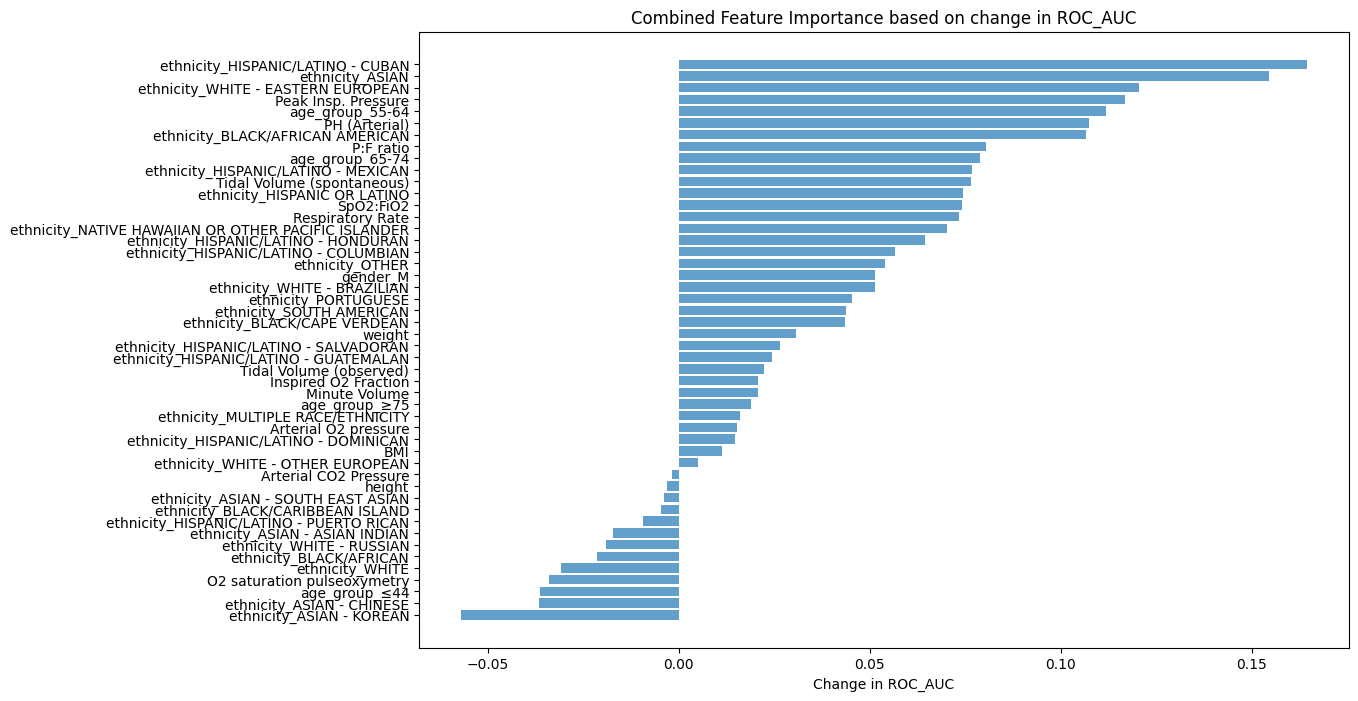

In [ ]:
feature_importances_exp_2 = feature_ablation_with_names(train_sequences, train_static, train_labels, test_sequences, test_static, test_labels, final_model_exp_2, best_params_exp_2, device, dynamic_feature_names, static_feature_names)